In [1]:
using LinearAlgebra
using Interpolations
using Images
using Colors
using Plots
using Printf

In [2]:
#using BenchmarkTools

In [3]:
using Revise

In [4]:
using ScientificRT

┌ Info: Precompiling ScientificRT [5bc58e1e-5d7c-492b-bf1e-f34da4464f5b]
└ @ Base loading.jl:1260


# Set up volume

In [5]:
# Number of voxels in X, Y, Z directions
num_x_voxels = 100;
num_y_voxels = 100;
num_z_voxels = 100;
N_x = num_x_voxels - 1 # number of x intervals
N_y = num_y_voxels - 1 # number of y intervals
N_z = num_z_voxels - 1 # number of z intervals

io = open("../../data/perlin_noise/test2_alt.raw", "r");
raw_data = Array{Float32, 1}(undef, num_x_voxels*num_y_voxels*num_z_voxels);
read!(io, raw_data);
volume = reshape(raw_data,num_x_voxels,num_y_voxels,num_z_voxels);

ℹ️ Here we are assuming cell-centered data. We sample onto a dual grid where the cell centers act as the vertices. Therefore, the number of intervals on each dimension is the number of voxels minus 1.

## Data read
Read the data from binary file as an array of floats (code snippet from [StackOverflow post by "chunjiw"](https://stackoverflow.com/users/4966531/chunjiw))

## Set up interpolation
ℹ️ Assumption: Corners of volume are from (-0.5,-0.5,-0.5) to (0.5,0.5,0.5)

In [6]:
x_len = 1.0
y_len = 1.0
z_len = 1.0

x_step = ScientificRT.interval_width(x_len,N_x)
y_step = ScientificRT.interval_width(y_len,N_y)
z_step = ScientificRT.interval_width(z_len,N_z)

bbox_min = [-0.5;-0.5;-0.5]
bbox_max = [0.5;0.5;0.5]

xs = bbox_min[1]:x_step:bbox_max[1]
ys = bbox_min[2]:y_step:bbox_max[2]
zs = bbox_min[3]:z_step:bbox_max[3]

vol_trilinear = LinearInterpolation((xs, ys, zs), volume, extrapolation_bc = 0.0);

# Set up raycast

### Camera aligned with cube

In [7]:
W = 640;
H = 480;
fovy = π/2;
eye_pos = [0.0;0.0;2.0];
up = [0.0;1.0;0.0];
view_dir = [0.0,0.0,-1.0];

In [8]:
pix_coords = pixel_indices(W,H);
raygen_func = get_raygen(W, H, fovy, eye_pos, up, view_dir);
rays = raygen_func.(pix_coords);

### Camera looking in "diagonal" direction

In [9]:
r_cam = 2.0
θ_cam = π/4
ϕ_cam = π/4

tgt = [0.0;0.0;0.0]
eye_pos_alt = sph2cart(r_cam,θ_cam,ϕ_cam)
vdir_alt = normalize(tgt - eye_pos_alt)
up_alt = get_up(θ_cam, ϕ_cam)

raygen_f_altview = get_raygen(W, H, fovy, eye_pos_alt, up_alt, vdir_alt);
rays_altview = raygen_f_altview.(pix_coords);

# Volume Rendering

## Test against bounding cube

In [10]:
cube_t_near = ray_cube_intersect.(rays);
cube_t_far = ray_cube_intersect.(rays, false);

In [11]:
cube_altview_tnear = ray_cube_intersect.(rays_altview);
cube_altview_tfar = ray_cube_intersect.(rays_altview, false);

## Maximum Intensity Projection

In [12]:
@assert ScientificRT.interval_width(x_len,N_x) == ScientificRT.interval_width(y_len,N_y);
@assert ScientificRT.interval_width(y_len,N_y) == ScientificRT.interval_width(z_len,N_z);
step_size = ScientificRT.interval_width(x_len,N_x)/2;
raymarch_MIP = get_raymarch_MIP(vol_trilinear, step_size, bbox_min, bbox_max);

In [13]:
test_row = 200
test_col = 350
test_ray = rays[test_row,test_col];
test_t_near = cube_t_near[test_row,test_col];
test_t_far = cube_t_far[test_row,test_col];

In [14]:
raymarch_MIP(test_ray,test_t_near,test_t_far)

1.0

In [15]:
MIP_result = raymarch_MIP.(rays, cube_t_near, cube_t_far)

480×640 Array{Float64,2}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  Na

In [16]:
heatmap(MIP_result)

In [17]:
σ_t = get_σ_t(test_ray, vol_trilinear)

#7 (generic function with 1 method)

In [18]:
test_ray_range = test_t_near:0.001:test_t_far;
probeResults = [sample_vol_with_ray(test_ray, t, vol_trilinear) for t in test_ray_range]; 

In [19]:
plot(probeResults)

In [20]:
σ_t_max = 1
σ_sampler = sampler_factory(test_t_near, σ_t, σ_t_max, dist_until_interact);

In [21]:
approx_transmittances = est_transmittance.(σ_sampler, test_ray_range, 10000);

In [22]:
plot(approx_transmittances, ylims=[0.0,1.0])

In [23]:
getter = get_σ_t_wrapper(rays,vol_trilinear)
σ_t_array = getter.(rays)
σ_sampler_array = sampler_factory.(cube_t_near, σ_t_array, σ_t_max, dist_until_interact);

In [24]:
est_transmittance(σ_sampler_array[test_row,test_col], cube_t_far[test_row,test_col], 1000)

0.823

In [25]:
transmittance_array_100 = transmittance_rays(σ_t_array, σ_sampler_array, cube_t_far, 100);

In [26]:
transmittance_array_1000 = transmittance_rays(σ_t_array, σ_sampler_array, cube_t_far, 1000);

In [27]:
transmittance_array_10000 = transmittance_rays(σ_t_array, σ_sampler_array, cube_t_far, 10000);

In [28]:
heatmap(transmittance_array_100)

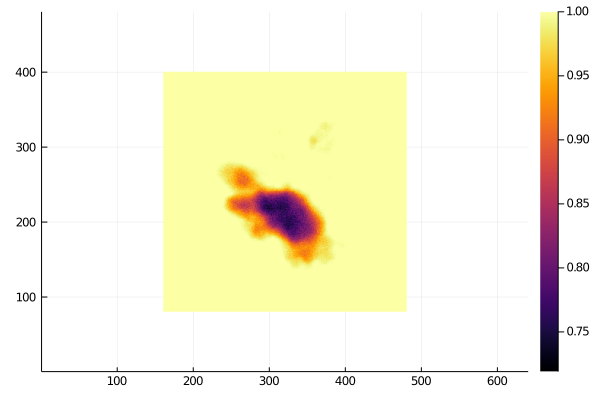

In [29]:
heatmap(transmittance_array_1000)

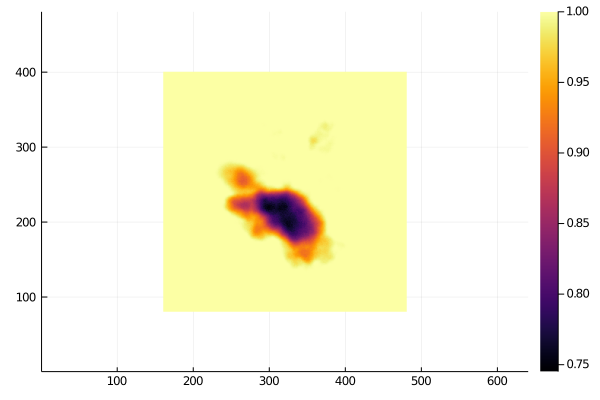

In [30]:
heatmap(transmittance_array_10000)

In [31]:
MIP_result_altview = raymarch_MIP.(rays_altview, cube_altview_tnear, cube_altview_tfar);

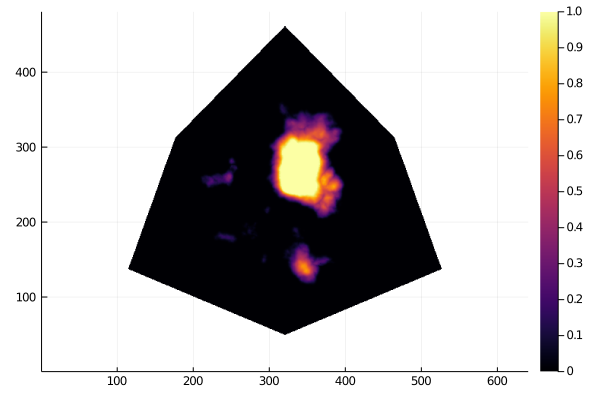

In [32]:
heatmap(MIP_result_altview)

In [40]:
getter_alt = get_σ_t_wrapper(rays_altview,vol_trilinear)
σ_t_array_alt = getter_alt.(rays);
σ_samplers_alt = sampler_factory.(cube_altview_tnear, σ_t_array_alt, σ_t_max, dist_until_interact);

In [41]:
transmittance_alt_100 = transmittance_rays(σ_t_array_alt, σ_samplers_alt, cube_altview_tfar, 100);

In [42]:
transmittance_alt_1000 = transmittance_rays(σ_t_array_alt, σ_samplers_alt, cube_altview_tfar, 1000);

In [43]:
transmittance_alt_10000 = transmittance_rays(σ_t_array_alt, σ_samplers_alt, cube_altview_tfar, 10000);

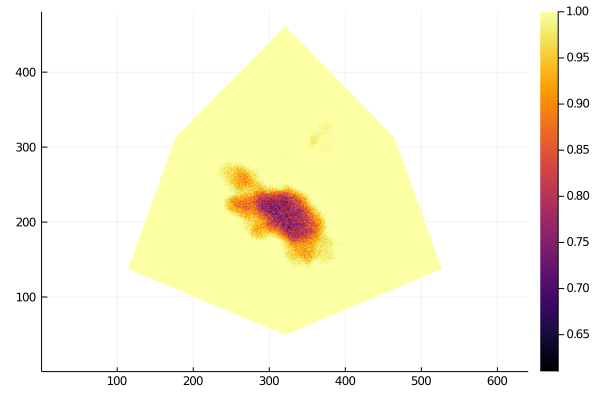

In [44]:
heatmap(transmittance_alt_100)

In [45]:
heatmap(transmittance_alt_1000)

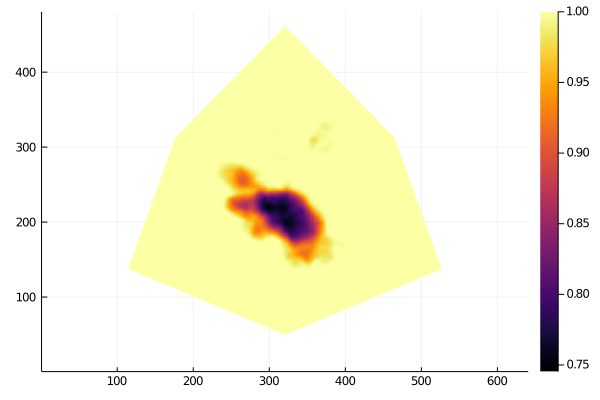

In [46]:
heatmap(transmittance_alt_10000)